
<a id='chap-tpevaluationselectionmodeles'></a>

# Evaluation and decisional models selection

The objective of this notebook is to use cross-validation technics and decisionnal models comparison as well as hyper-parameters values research methods (like the regularisation coefficient)

External references :

- [NumPy documentation](https://docs.scipy.org/doc/numpy/user/index.html)  
- [SciPy documentation](https://docs.scipy.org/doc/scipy/reference/)  
- [MatPlotLib documentation](http://matplotlib.org/)  
- [Scikit-learn website](http://scikit-learn.org/stable/index.html)  
- [Python website](https://www.python.org)  

## Performance evaluation using cross-validation

In order to illustrate the cross-validation method, we will use the labelled [Fisher's Iris data set](https://fr.wikipedia.org/wiki/Iris_de_Fisher). We want to determine to which species belong a plant among three possibilities (*Iris Setosa*, *Iris Virginica* et *Iris Versicolor*) knowing lenght and width of the sepal and petals

We will use a multi-layer perceptron (MLP) with one hidden layer of 100 neurons and with a value $ \alpha = 1 $ for the regulation constant

Cross-validation will be used to estimate generalization performances *from the training data set*. Next, this estimation will be compared to the one obtain on the test data set. Explication on cross-validation technics and its implementation in Scikit-learn can be found [in the documentation](http://scikit-learn.org/stable/modules/cross_validation.html).

In [2]:
# importations
import numpy as np
import matplotlib.pyplot as plt
import sklearn

# Iris dataset download
from sklearn import datasets
iris = datasets.load_iris()
data, labels = iris.data, iris.target

# Split into a training and a test datasets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.5)

train_test_split function from scikit-learn allow us to split the data set into two partitions : train (learning) and test (evaluation) accordingly to a determined ration. 

Let's visualize the data as point cloud in two dimension with Matplotlib

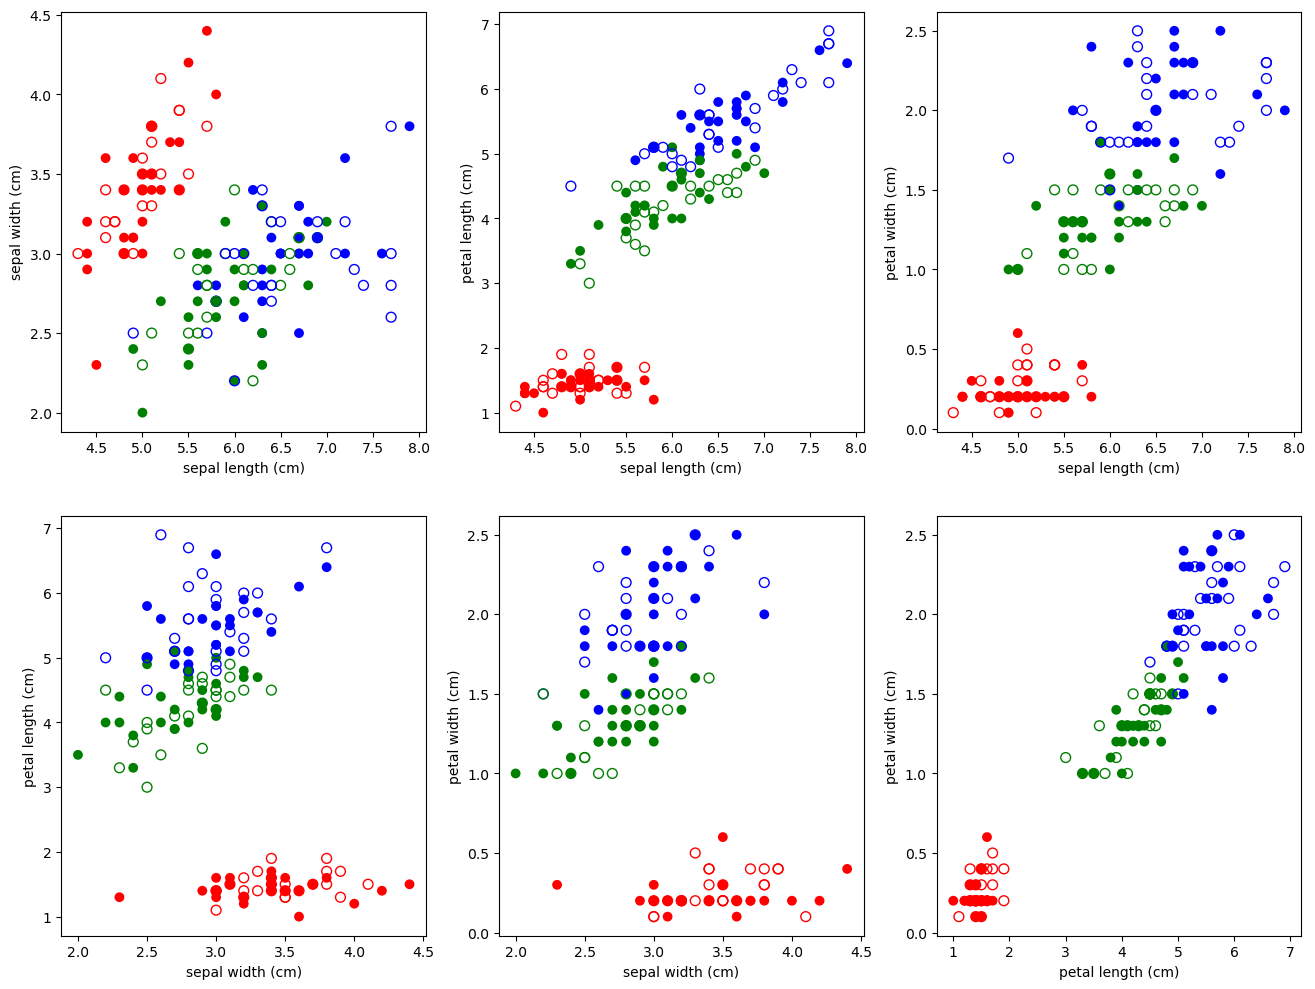

In [3]:
fig = plt.figure(figsize=(16, 12))
n_features = data.shape[-1]
n_plots = 6
idx = 1
cmp = np.array(['r', 'g', 'b'])
for dim1 in range(0, n_features):
    for dim2 in range(dim1+1, n_features):
        fig.add_subplot(2, n_plots // 2, idx)
        plt.scatter(X_train[:, dim1], X_train[:, dim2],c=cmp[y_train], s=50, edgecolors='none')
        plt.scatter(X_test[:,  dim1], X_test[:, dim2], c='none',  s=50, edgecolors=cmp[y_test])
        plt.xlabel(iris.feature_names[dim1])
        plt.ylabel(iris.feature_names[dim2])
        idx += 1
plt.show()

There is a point cloud for every pair of variable so we obtain six graphics. Each graphic represents the projection of the dataset on two dimensions

For this classification problem, we will use a MLP with defaults values for the hidden layers (1) and the number of neurons (100).

In [4]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1, tol=5e-3)

To estimate the generalization error, we will use the K-fold cross-validation. This will allow us to tune, if necessary, the hyperparameters of the decision model. Scikit-learn implements various cross-validation strategies in the sklearn.model_selection module. Let's start experimenting with the K-fold approach. The KFold object has a .split() method that generates lists of indices of observations to use for the training subset and the validation subset. More details about this object can be found in the [KFold documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

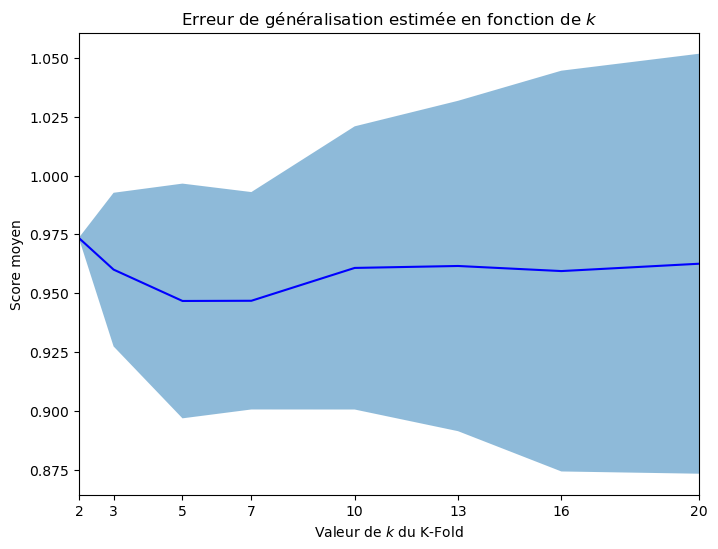

In [5]:
# KFold pour différentes valeurs de k
from sklearn.model_selection import KFold

# valeurs de k
n_folds = np.array([2, 3, 5, 7, 10, 13, 16, 20])

# préparation des listes pour stocker les résultats
cv_scores = []
cv_scores_std = []

for k in n_folds:    # pour chaque valeur de k
    kf = KFold(n_splits=k)
    scores = []
    # apprentissage puis évaluation d'un modèle sur chaque split
    for train_idx, val_idx in kf.split(X_train):
        # apprentissage avec .fit()
        clf.fit(X_train[train_idx], y_train[train_idx])
        scores.append(clf.score(X_train[val_idx], y_train[val_idx]))
    # calcul de la moyenne et de l'écart-type des performances obtenues
    cv_scores.append(np.mean(scores))
    cv_scores_std.append(np.std(scores))

cv_scores, cv_scores_std = np.array(cv_scores), np.array(cv_scores_std)

# affichage performance moyenne +- 1 écart-type pour chaque k
plt.figure(figsize=(8, 6))
plt.plot(n_folds, cv_scores, 'b')
plt.fill_between(n_folds, cv_scores + cv_scores_std, cv_scores - cv_scores_std, alpha=0.5)
plt.xlabel("Valeur de $k$ du K-Fold")
plt.ylabel("Score moyen")
plt.xlim(2, max(n_folds))
plt.xticks(n_folds)
plt.title("Erreur de généralisation estimée en fonction de $k$")
plt.show()

## Question :

Que constatez-vous en examinant ce graphique ? Ajoutez des valeurs pour *k* (par ex. 40, 100, attention ce sera plus long…) et examinez de nouveau le graphique.

## Correction :

On constate que, lors de l’augmentation de *k*, la performance moyenne se stabilise mais la variance augmente. Cela s’explique par le fait que, lorsque la valeur de *k* augmente, l’évaluation est faite (c’est à dire la moyenne de l’erreur est calculée) sur de moins en moins de données. La variance augmente encore pour des valeurs supérieures de *k*.

## Question :

Pour chaque modèle appris par validation croisée *k-fold*, ajoutez son évaluation sur les données de test mises de côté au départ `X_test, y_test`. Affichez les courbes sur le même graphique. Que constatez-vous ?

## Correction :

On ajoute des listes pour stocker ces résultats et on affiche leurs contenus :

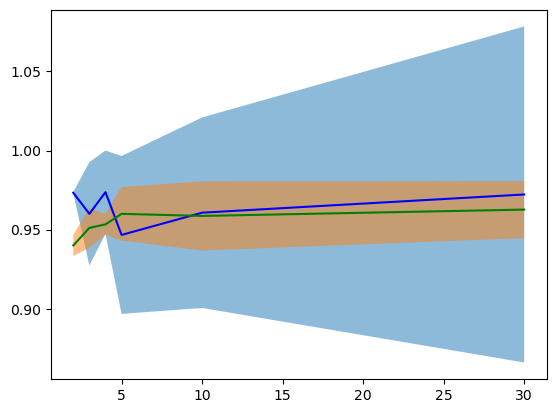

In [6]:
kcv_scores = list()
kcv_scores_std = list()
test_scores = list()
test_scores_std = list()

kcvfs = [2, 3, 4, 5, 10, 30]

for kcvf in kcvfs:    # pour chaque valeur de k
  kf = KFold(n_splits=kcvf)
  these_scores = list()
  these_test_scores = list()
  # apprentissage puis évaluation d'un modèle sur chaque split
  for train_idx, test_idx in kf.split(X_train):
    clf.fit(X_train[train_idx], y_train[train_idx])
    these_scores.append(clf.score(X_train[test_idx], y_train[test_idx]))
    these_test_scores.append(clf.score(X_test, y_test))
  # calcul de la moyenne et de l'écart-type des performances obtenues
  kcv_scores.append(np.mean(these_scores))
  kcv_scores_std.append(np.std(these_scores))
  test_scores.append(np.mean(these_test_scores))
  test_scores_std.append(np.std(these_test_scores))

# création de np.array à partir des listes
kcv_scores, kcv_scores_std = np.array(kcv_scores), np.array(kcv_scores_std)
test_scores, test_scores_std = np.array(test_scores), np.array(test_scores_std)

# affichage performance moyenne +- 1 écart-type pour chaque k
plt.figure()
plt.plot(kcvfs, kcv_scores, 'b')
plt.fill_between(kcvfs, kcv_scores + kcv_scores_std, kcv_scores - kcv_scores_std, alpha=0.5)
plt.plot(kcvfs, test_scores, 'g')
plt.fill_between(kcvfs, test_scores + test_scores_std, test_scores - test_scores_std, alpha=0.5)

Les résultats montrent que l’estimation de l’erreur de généralisation par validation croisée sur les données d’apprentissage (courbes en bleu) reste en général optimiste par rapport à l’estimation sur des données de test supplémentaires (courbes en vert). Aussi, la variance des estimations sur les données de test est comparativement faible car ces données sont ici aussi volumineuses que les données d’apprentissage (`test_size=0.5`).

## Question :

Réalisez l’estimation des performances en utilisant la [validation croisée leave one out (LOO)](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut). Que constatez-vous en comparant les résultats de *k-fold* et de *leave one out* ?

## Correction :

In [7]:
# LOO
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
loo.get_n_splits(X_train)

loo_scores = list()
for train_idx, test_idx in loo.split(X_train):
  clf.fit(X_train[train_idx], y_train[train_idx])
  loo_scores.append(clf.score(X_train[test_idx], y_train[test_idx]))

np.mean(loo_scores)
np.std(loo_scores)

0.19595917942265426

On constate que l’écart-type est bien plus élevé pour l’estimation *leave one out* que pour les estimations *k-fold* (pour toutes les valeurs considérées ici pour *k*).

## Note

Pour l’illustration, nous avons itéré ici manuellement à l’aide des itérateurs KFold et LeaveOneOut. Toutefois il est possible d’automatiser ce procédé dans le cas du *KFold* à l’aide de la fonction cross_val_score:

> > 

In [8]:
from sklearn.model_selection import cross_val_score
clf = MLPClassifier(solver='lbfgs', alpha=1, tol=5e-3)

# Cross-validation KFold avec k=5
scores = cross_val_score(clf, X_train, y_train, cv=5)


Cette fonction prend des paramètres supplémentaires (métriques, parallélisation, etc.) qui sont décrites dans [sa documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score).

## Évaluation d’un classifieur binaire

Précédemment, nous avons évalué le modèle en calculant le taux de bonnes prédictions (*accuracy*). Néanmoins, cette métrique est biaisée en faveur des classes les plus représentées lorsque le jeu de données est déséquilibré. Une alternative courante, notamment dans le cas de la classification binaire, est de s’intéresser au taux de faux positifs et au taux de faux négatifs.

Pour illustrer ces concepts, considérons le jeu de données *Breast Cancer Wisconsin*. Ce jeu de données comporte 569 observations pour 30 variables médicales obtenues par biopsie. Les observations sont réparties dans deux classes: tumeur maligne (0) ou tumeur bénigne (1).

In [9]:
from sklearn.datasets import load_breast_cancer
# Chargement des données *Breast Cancer Wisconsin*
X, y = load_breast_cancer(return_X_y=True)

## Question

Combien y a-t-il de tumeurs bénignes dans ce jeu de données? De tumeurs malignes?

## Correction

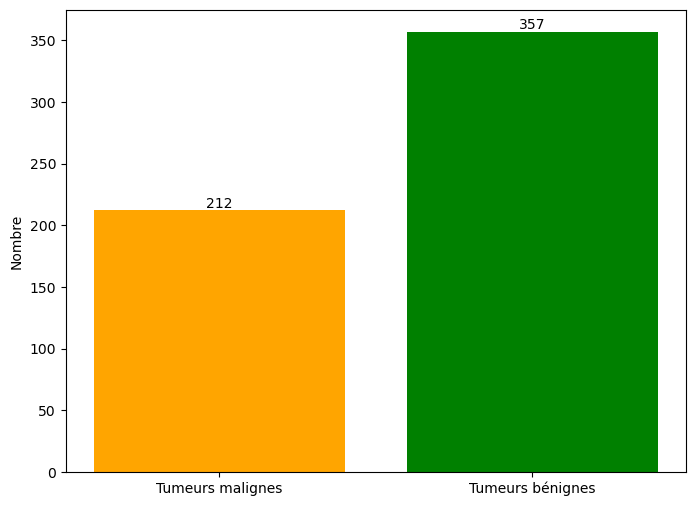

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar([0,1], np.bincount(y), color=['orange', 'green'])
ax.bar_label(bars)
plt.xticks(ticks=[0,1], labels=["Tumeurs malignes", "Tumeurs bénignes"])
plt.ylabel("Nombre")
plt.show()

Dans un premier temps, nous allons diviser le jeu de données en deux : un jeu d’apprentissage et un jeu de validation. Comme il s’agit d’un problème de classification binaire, nous allons tracer la courbe ROC (*Receiver Operating Characteristic*), qui correspond au taux de vrais positifs en fonction du taux de faux positifs.

In [11]:
# Division du jeu de données (50%/50%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

Entraînons deux modèles sur ce jeu de données : un percepton multi-couches (MLPClassifier) et une analyse factorielle discriminante (LinearDiscriminantAnalysis).

In [12]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=50, alpha=1e-5, max_iter=1000, solver='adam', random_state=0)
mlp.fit(X_train, y_train)
print(f"Accuracy du MLP: {mlp.score(X_test, y_test)*100:.1f}%")


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print(f"Accuracy de la LDA: {lda.score(X_test, y_test)*100:.1f}%")

Accuracy du MLP: 93.0%
Accuracy de la LDA: 95.8%


Comme nous l’avons vu, l”*accuracy* est une métrique biaisée en faveur de la classe la plus représentée. À la place, nous pouvons calculer la précision et le rappel pour chaque classe. Dans notre cas, c’est notamment la précision et le rappel sur la classe 0 (tumeur maligne) qui nous intéresse : cela nous permettra d’évaluer combien de fausses alarmes ont été produites et combien de tumeur malignes ont été « ratées ».

scikit-learn propose une [fonction bien utile](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) permettant de résumer ces métriques de classification :

In [13]:
from sklearn.metrics import classification_report

print("\t========= Métriques pour le MLP ============")
print(classification_report(y_test, mlp.predict(X_test)))

	========= Métriques pour le MLP ============
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       101
           1       0.95      0.94      0.95       184

    accuracy                           0.93       285
   macro avg       0.92      0.93      0.92       285
weighted avg       0.93      0.93      0.93       285



## Question

Calculer ces mêmes métriques pour l’analyse factorielle discriminante (*LDA*).

## Correction

In [14]:
print("\t========= Métriques pour la LDA ============")
print(classification_report(y_test, lda.predict(X_test)))

	========= Métriques pour la LDA ============
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       101
           1       0.95      0.99      0.97       184

    accuracy                           0.96       285
   macro avg       0.96      0.95      0.95       285
weighted avg       0.96      0.96      0.96       285



Pour tracer la courbe ROC, nous devons maintenant calculer les taux de vrais positifs et de faux positifs pour différentes valeurs du seuil de classification. La plupart des classifieurs produisent en sortie une probabilité d’appartenance à chaque classe, entre 0 et 1. Si l’on ne spécifie rien, la règle consiste la plupart du temps à assigner une observation $ x $ à la classe $ k $ si la probabilité assignée par le modèle pour $ x $ à la $ k $ est supérieure à 0,5. Toutefois, nous pouvons faire varier ce seuil. Si on diminue le seuil, alors de plus en plus d’observations sont assignées à la classe $ k $: le taux de vrais positifs augmente mais le taux de faux positifs aussi. Et inversement si l’on diminue ce seuil.

La courbe ROC correspondent à l’ensemble des points (taux de faux positifs, taux de vrais positifs) obtenus en faisant varier le seuil de décision entre 0 et 1.

scikit-learn permet de calculer automatiquement les taux de vrais positifs et faux positifs pour différents points de fonctionnement à l’aide de la méthode `metrics.roc_curve` (cf. [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)):

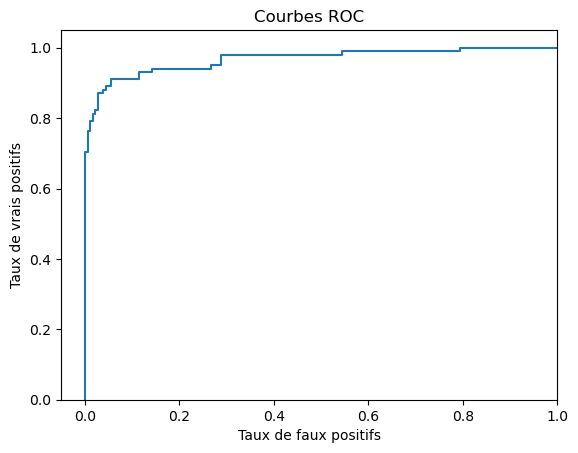

In [15]:
from sklearn.metrics import roc_curve

# Calcul de la courbe ROC
# `pos_label` permet d'indiquer que l'étiquette "positive" (tumeur maligne")
# correspond à la valeur 0
fpr, tpr, thresholds = roc_curve(y_test, mlp.predict_proba(X_test)[:,0], pos_label=0)

plt.plot(fpr, tpr, label="MLP")
plt.xlim(-0.05, 1)
plt.ylim(0, 1.05)
plt.title("Courbes ROC")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.show()

## Question

Calculer et tracer en superposition la courbe ROC pour la *LDA*. Quel modèle vous semble le plus approprié pour ce jeu de données ? Quelle métrique pourrait-on calculer pour confirmer cette hypothèse ?

## Correction

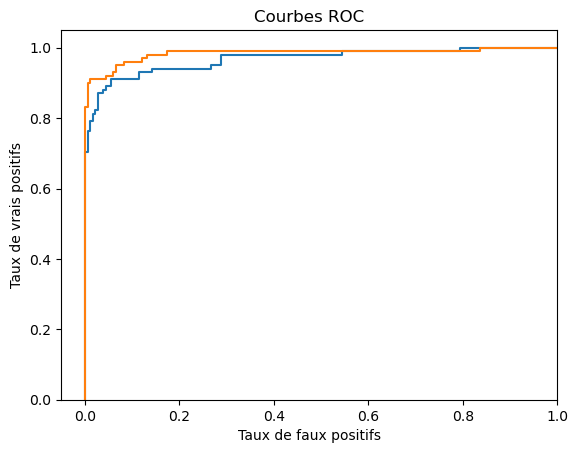

In [16]:
from sklearn.metrics import roc_curve

# Calcul de la courbe ROC
# `pos_label` permet d'indiquer que l'étiquette "positive" (tumeur maligne")
# correspond à la valeur 0
fpr, tpr, thresholds = roc_curve(y_test, mlp.predict_proba(X_test)[:,0], pos_label=0)

plt.plot(fpr, tpr, label="MLP")
fpr, tpr, thresholds = roc_curve(y_test, lda.predict_proba(X_test)[:,0], pos_label=0)
plt.plot(fpr, tpr, label="LDA")
plt.xlim(-0.05, 1)
plt.ylim(0, 1.05)
plt.title("Courbes ROC")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.show()

## Question

On souhaite un taux de faux positifs inférieur à 10% (c’est-à-dire que moins d’une tumeur prédite comme « maligne » sur 10 soit en réalité bénigne). Déterminer pour le modèle de votre choix la valeur du seuil pour la classe 0 (tumeur maligne) permettant d’atteindre cet objectif. À quel taux de vrais positifs cela correspond-t-il ?

## Correction

### Pour aller plus loin

Pour simplifier, nous avons ici considéré une division *train/test* en deux parties. Toutefois, comme nous l’avons vu précédemment, il serait plus rigoureux de réaliser une validation croisée, par exemple *K-Fold*. scikit-learn permet de réaliser une validation croisée en spécifiant la métrique à conserver.

### Question

(*À terminer chez vous*) Réaliser une validation croisée *KFold* sur le modèle de votre choix en utilisant l’aire sous la courbe ROC (`metrics.roc_auc_score`) comme métrique de référence. La [<documentation de la validation croisée avec scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics) pourra vous être utile.

### Correction

In [17]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(mlp, X, y, cv=5, scoring='roc_auc')

### Note

Bien que la courbe ROC soit définie dans le cadre de la classification binaire, il est possible de l’étendre au cadre multiclasse. Dans ce cas, on moyenne généralement plusieurs courbes ROC, en considérant des classifieurs binaires *one-versus-all* pour chacune des classes. Voir [cet exemple de scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) pour plus de détails.

## Recherche des meilleures valeurs pour les hyperparamètres

Une des problématiques centrales en modélisation décisionnelle est de pouvoir déterminer les hyperparamètres du modèle qui débouchent sur les meilleurs performances. Formellement, cela revient à chercher la famille paramétrique qui obtient l’erreur de généralisation la plus faible. Néanmoins, comme nous l’avons vu, nous ne pouvons pas utiliser le jeu d’évaluation pour comparer des centaines de modèles : l’estimation de l’erreur généralisation deviendrait bien trop optimiste. Nous allons donc utiliser la validation croisée pour comparer nos modèles, puis seulement une fois les meilleures valeurs des hyperparamètres déterminées pourrons nous estimer l’erreur de généralisation sur le jeu de test.

La méthode la plus naïve pour la recherche d’hyperparamètres est la recherche systématique, ou *grid search*. Elle consiste à explorer toutes les combinaisons de valeurs possibles dans un ensemble donné.

Utilisons *grid search* pour trouver les meilleures valeurs de deux hyperparamètres pour les PMC dans la même tâche de classement que précédemment. Ces hyperparamètres sont le nombre de neurones dans l’unique couche cachée du PMC et la valeur de la constante de régularisation (par *weight decay*), $ \alpha $.

In [18]:
# importations
import numpy as np
import matplotlib.pyplot as plt

# chargement des données iris
from sklearn import datasets
data, labels = datasets.load_iris(return_X_y=True)

# découpage initial en données d'apprentissage et données de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.5)

# emploi de PMC
from sklearn.neural_network import MLPClassifier

Afin d’utiliser la [recherche dans une grille](http://scikit-learn.org/stable/modules/grid_search.html) et la validation croisée pour comparer les modèles obtenus avec toutes les combinaisons de valeurs pour les hyperparamètres, il est nécessaire d’employer [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). Cet estimateur scikit-learn combine automatiquement une rechercher par grille avec une validation croisée *K-fold*.

> 

In [19]:
from sklearn.model_selection import GridSearchCV


Il est nécessaire d’indiquer dans un « dictionnaire » quels sont les hyperparamètres dont on souhaite explorer les valeurs et quelles sont les différentes valeurs à évaluer. Chaque entrée du dictionnaire consiste en une chaîne de caractères qui contient le nom de l’hyperparamètre tel qu’il est défini dans l’estimateur employé. Nous nous servirons ici de `MLPClassifier`, les noms des paramètres peuvent donc être trouvés dans [la présentation de cette classe](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier). Nous considérons ici seulement deux paramètres, `hidden_layer_sizes` (nombre de neurones dans l’unique couche cachée) et `alpha` (la constante $ \alpha $ de régularisation par *weight decay*).

In [20]:
tuned_parameters = {'hidden_layer_sizes':[(5,), (20,), (50,), (100,), (150,), (200,)],
                    'alpha':   [0.001, 0.01, 1, 2]}

Dans l’appel de `GridSearchCV` nous indiquons ensuite pour `MLPClassifier` le solveur à utiliser systématiquement (qui n’est pas celui par défaut), ensuite le dictionnaire avec les valeurs des  (hyper)paramètres à explorer et enfin le fait que c’est la validation croisée *k-fold* avec $ k=5 $ qui est employée pour comparer les différents modèles.

In [21]:
clf = GridSearchCV(MLPClassifier(solver='lbfgs', tol=5e-3), tuned_parameters, cv=5)

# exécution de grid search
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(solver='lbfgs', tol=0.005),
             param_grid={'alpha': [0.001, 0.01, 1, 2],
                         'hidden_layer_sizes': [(5,), (20,), (50,), (100,),
                                                (150,), (200,)]})

Scikit-learn exécute alors le programme suivant :

- à partir des listes de valeurs pour les différents (hyper)paramètres sont générées toutes les combinaisons de valeurs,  
- pour chaque combinaison, les performances des modèles correspondants sont évaluées par validation croisée *5-fold* (appliquée uniquement sur les **données d’apprentissage** `X_train, y_train`),  
- sont sélectionnées les valeurs des (hyper)paramètres correspondant aux meilleures performances de validation croisée,  
- avec ces valeurs pour les (hyper)paramètres un nouvel apprentissage est réalisé avec la totalité des données de `X_train, y_train` (et non seulement $ \frac{k-1}{k} $ *folds*).  


Les lignes suivantes permettent d’afficher les résultats : les paramètres du meilleur modèle avec `clf.best_params_`, ainsi que les résultats de validation croisée obtenus pour toutes les combinaisons de valeurs pour les (hyper)paramètres (`clf.cv_results_` donne accès à ces informations et à bien d’autres).

In [22]:
print(clf.best_params_)

{'alpha': 1, 'hidden_layer_sizes': (50,)}


Nous pouvons également faire un affichage plus complet, traçant la surface du score moyen des différentes modèles en fonction de la combinaison des deux hyperparamètres :

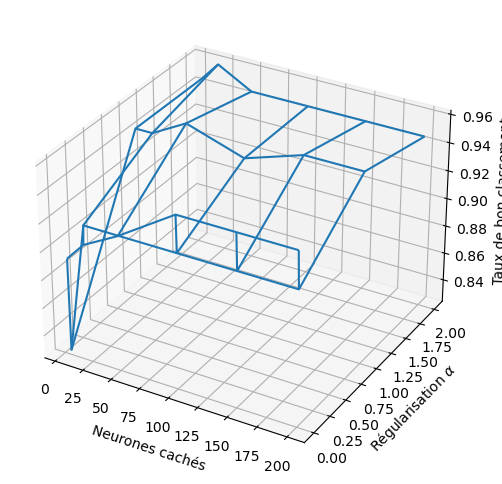

In [23]:
n_hidden = np.array([s[0] for s in tuned_parameters['hidden_layer_sizes']])
alphas = np.array(tuned_parameters['alpha'])

# création de la grille des hyperparamètres
xx, yy = np.meshgrid(n_hidden, alphas)
scores = clf.cv_results_['mean_test_score'].reshape(xx.shape)

# affichage sous forme de fil de fer de la surface des résultats des modèles évalués
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.set_xlabel("Neurones cachés")
ax.set_ylabel("Régularisation $\\alpha$")
ax.set_zlabel("Taux de bon classement")
ax.plot_wireframe(xx, yy, scores)
plt.show()

Nous avons employé ici `plot_wireframe` car la lisibilité est meilleure qu’avec `plot_surface`.

## Question :

Combien de PMC sont appris au total dans cet exemple ?

## Correction :

Le nombre de combinaisons de (hyper)paramètres explorées est `len(tuned_parameters['hidden_layer_sizes']) * len(tuned_parameters['alpha'])` = 24. Pour chacune de ces combinaisons, `cv=5` indique que $ k = 5 $ PMC différents sont appris. Donc un total de 24 * 5 = 120.

## Question :

Quelle est la signification du paramètre `refit` de `GridSearchCV` ?

## Correction :

Comme indiqué dans la [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV), si la valeur de ce paramètre est `True` (valeur par défaut) alors, une fois trouvées les meilleures valeurs pour les hyperparamètres, un nouveau modèle est appris avec ces valeurs-là sur la totalité des $ N $ données d’apprentissage `X_train, y_train` (sans en exclure $ N/k $). Ce modèle est directement accessible dans l’attribut `.best_estimator_` et l’appel à `.predict()` sur l’instance de `GridSearchCV` (ici `clf`) permet de l’utiliser.

## Question :

Examinez de façon plus complète le contenu de `clf.cv_results_`.

## Correction :

Regarder les explications concernant cet attribut dans la [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV).

## Question :

Evaluez le modèle sélectionné sur les données de test (`X_test, y_test`).

## Correction :

> Le paramètres `refit` étant par défaut `True`, le modèle appris avec les meilleures valeurs pour les hyperparamètres est directement accessible via l’instance de `GridSearchCV` (ici `clf`), donc pour l’évaluer sur les données de test il suffit d’écrire

In [24]:
clf.score(X_test, y_test)

0.96

## Question :

L’aspect des résultats vous incite à affiner la grille ? Modifiez la grille et examinez les nouveaux résultats.

## Correction :

Il est surtout intéressant d’affiner la grille autour des valeurs optimales pour les (hyper)paramètres, lues sur le graphique affiché ou obtenues avec `clf.best_params_`. Il faut définir une nouvelle grille plus fine autour de ce point et appeler de nouveau `GridSearchCV`.

## Question :

Utilisez la recherche aléatoire avec [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). Le « budget » (nombre total de combinaisons évaluées) peut être fixé avec `n_iter`. Motivez le choix des lois employées pour le tirage des valeurs des deux (hyper)paramètres `hidden_layer_sizes` et `alpha`.

## Correction :

> Les distributions peuvent être choisies dans [cette liste de scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html). Les distributions continues doivent être préférées pour les paramètres continus (comme $ \alpha $ ici) et les distributions discrètes pour les paramètres discrets (comme le nombre de neurones dans la couche cachée). Les distributions uniformes (`uniform`, respectivement `randint`) sont la solution de facilité. Si des connaissances *a priori* nous permettent de préférer certains points de l’espace des paramètres, alors nous pouvons choisir d’autres distributions qui privilégient les voisinages de ces points. L’appel à `RandomizedSerchCV` aura la forme

In [25]:
rlf = RandomizedSerchCV(MLPClassifier(solver='lbfgs'), param_distributions=param_distrib, n_iter=50, cv=5)

NameError: name 'RandomizedSerchCV' is not defined

où `param_distrib` est le dictionnaire qui précise les distributions employées pour les différents (hyper)paramètres et `n_iter=50` indique un « budget » de 50 essais.

### Pour aller plus loin

D’autres stratégies plus avancées de sélection d’hyperparamètres sont envisageables. En effet, la recherche par grille, comme la recherche aléatoire, sont des méthodes relativement rudimentaires et plutôt coûteuses en ressources. Cela peut notamment poser problème lorsque les modèles décisionnels que l’on considère appartiennent à une famille paramétrique coûteuse en calculs, comme les réseaux de neurones profonds.

scikit-learn propose ainsi une implémentation expérimentale d’une recherche par dichotomie, permettant de concentrer les ressources sur les combinaisons d’hyperparamètres les plus prometteuses.

### Question

(*À terminer chez vous*) Expérimenter avec HalvingGridSearchCV (cf. [la documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html#sklearn.model_selection.HalvingGridSearchCV)). Comparer notamment le score final et le temps de calcul à celui obtenu avec GridSearchCV.

### Note

Hors de scikit-learn, il existe également d’autres bibliothèques implémentant des stratégies avancées de sélection utilisant diverses heuristiques pour choisir les combinaisons d’hyperparamètres à explorer. Certaines de ces bibliothèques sont compatibles avec l’interface de scikit-learn, par exemple [tune-sklearn](https://github.com/ray-project/tune-sklearn) ou encore [sklearn-genetic-opt](https://github.com/rodrigo-arenas/Sklearn-genetic-opt).